In [1]:
import HPA
import tomotopy as tp

In [122]:
corpus = HPA.load_corpus("tenders.hpa.corpus")
if corpus == None:
    docs = []
    import pandas as pd
    
    tenders_structured_path = r"../../../data/UpdatedAgainTenders.xlsx"
    tenders_structured = pd.read_excel(tenders_structured_path).astype(str)
    tenders_structured = tenders_structured[["Reference Number", "Contract Title", "Description"]].dropna(subset=["Reference Number"]).drop_duplicates(subset=["Reference Number"])

    from bs4 import BeautifulSoup
    def remove_html_tags(text):
        soup = BeautifulSoup(text, "html.parser")
        cleaned = soup.get_text().replace('\xa0', ' ')
        cleaned = ' '.join(cleaned.split())
        return cleaned

    for index, row in tenders_structured.iterrows():
        title = row["Contract Title"]
        desc = remove_html_tags(row["Description"])
        docs.append(title + ". " + desc)
    corpus = HPA.create_corpus(docs, "tenders.hpa.corpus")
    
model = tp.LDAModel(tw=tp.TermWeight.ONE, k = 2000, rm_top=3, corpus=corpus)
# refereed to as HPA but can train any of the models available
HPA.train(model, "tenders.hpa.tmm", stopping_factor = 1)

Num docs: 20619 , Vocab size: 24869 , Num words: 583348
Removed top words: ['services', 'department', 'provision']
Training...
Iteration: 00010	ll per word: -11.02880	perplexity: 61623.86074
Iteration: 00020	ll per word: -9.20467	perplexity: 9943.45557
Iteration: 00030	ll per word: -8.94802	perplexity: 7692.65079
Iteration: 00040	ll per word: -8.89095	perplexity: 7265.95397
Iteration: 00050	ll per word: -8.78139	perplexity: 6511.93825
Iteration: 00060	ll per word: -8.66441	perplexity: 5793.01155
Iteration: 00070	ll per word: -8.56916	perplexity: 5266.69480
Iteration: 00080	ll per word: -8.50327	perplexity: 4930.88048
Iteration: 00090	ll per word: -8.45227	perplexity: 4685.69742
Iteration: 00100	ll per word: -8.35559	perplexity: 4253.87692
Iteration: 00110	ll per word: -8.25479	perplexity: 3846.00207
Iteration: 00120	ll per word: -8.17062	perplexity: 3535.53699
Iteration: 00130	ll per word: -8.11625	perplexity: 3348.44955
Iteration: 00140	ll per word: -8.03792	perplexity: 3096.18112
Ite

In [2]:
model = tp.LDAModel.load("tenders.hpa.tmm")

In [124]:
print(model.docs[0])

<tomotopy.Document with words="supply delivery aspen bedding material customer requires contractor provide bedding material made aspen must suitable rats mice bedding material product must made entirely aspen species populus tremula">


In [3]:
lda_wd_cluster_topics = [HPA.get_topic_distribution(model, i, 1)[0][0] for i in range(0, len(model.docs))]

In [4]:
cluster_dict = {}
i = 0
for ct in lda_wd_cluster_topics:
    if ct not in cluster_dict:
        cluster_dict[ct] = i
        i += 1

In [5]:
from TendersWA import Panda
wd_tenders = Panda.load_tender_uniques(r"../../../data/UpdatedAgainTenders.xlsx")

In [6]:
wd_tenders["Topics"] = lda_wd_cluster_topics
wd_tenders["Cluster"] = 0
for index, row in wd_tenders.iterrows():
    wd_topics = row["Topics"]
    cluster = cluster_dict[wd_topics]
    wd_tenders.at[index, "Cluster"] = cluster
wd_tenders.reset_index(drop=True, inplace=True)

In [159]:
from TendersWA import Evaluation as eval
# bert score can take some time, upto 5m
def compute_evals(combined_df, use_summaries = False):
    references = list(combined_df["Description"])
    generates = list(combined_df["Topics"])
    rogue = eval.eval_rouge(references, generates)
    bert_precision, bert_recall, bert_f1 = eval.eval_bert_score(references, generates)
    return rogue, bert_precision, bert_recall, bert_f1

In [172]:
wd_rogue, wd_bert_p, wd_bert_r, wd_bert_f1 = compute_evals(wd_tenders)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [174]:
wd_evals = {"rouge": wd_rogue, "bs_precision": wd_bert_p, "bs_recall": wd_bert_r, "bs_f1": wd_bert_f1}

In [8]:
import pickle
def load_evals(fname):
    return pickle.load(open(fname, "rb"))
topic_eval_bert = load_evals("../../../notebooks/Evaluation/topic_eval_bert.cached.pickle")
topic_eval_sentence_transformer = load_evals("../../../notebooks/Evaluation/topic_eval_sentence_bert.cached.pickle")
topic_eval_summary = load_evals("../../../notebooks/Evaluation/topic_eval_summary.cached.pickle")
topic_eval_unspsc = load_evals("../../../notebooks/Evaluation/topic_eval_unspsc.cached.pickle")
topic_eval_manual = load_evals("../../../notebooks/Evaluation/topic_eval_manual.cached.pickle")

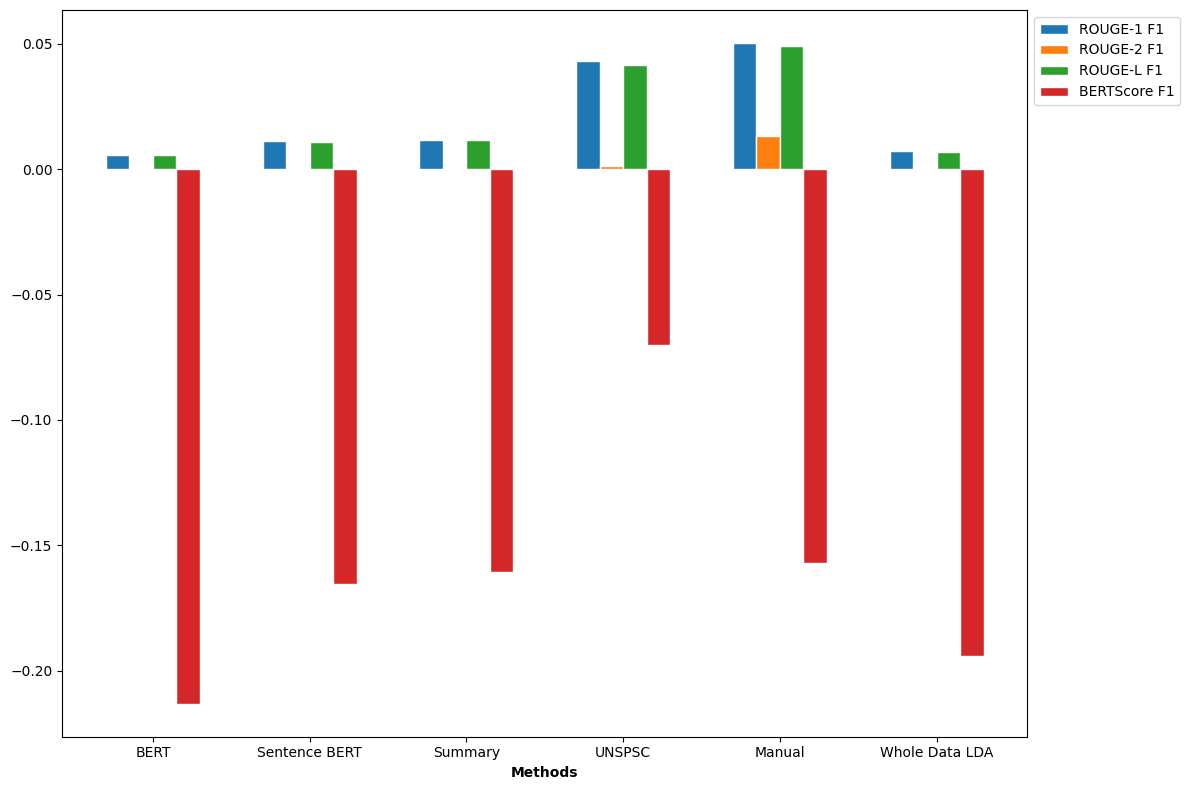

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def extract_average_metrics(data):
    """Extracts average metrics from the provided data."""
    avg_rouge1_f1 = np.mean([entry['rouge-1']['f'] for entry in data['rouge']])
    avg_rouge2_f1 = np.mean([entry['rouge-2']['f'] for entry in data['rouge']])
    avg_rougel_f1 = np.mean([entry['rouge-l']['f'] for entry in data['rouge']])
    avg_bs_f1 = np.mean(data['bs_f1'].numpy())  # Assuming you have PyTorch
    
    return avg_rouge1_f1, avg_rouge2_f1, avg_rougel_f1, avg_bs_f1

# Extract average metrics for each method
bert_metrics = extract_average_metrics(topic_eval_bert)
sentence_transformer_metrics = extract_average_metrics(topic_eval_sentence_transformer)
summary_metrics = extract_average_metrics(topic_eval_summary)
unspsc_metrics = extract_average_metrics(topic_eval_unspsc)
manual_metrics = extract_average_metrics(topic_eval_manual)
whole_data_lda_metrics = extract_average_metrics(wd_evals)

# Data to plot
n_methods = 6
f1_scores = [bert_metrics, sentence_transformer_metrics, summary_metrics, unspsc_metrics, manual_metrics, whole_data_lda_metrics]

# Create a bar plot
barWidth = 0.15
r1 = np.arange(n_methods)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
r4 = [x + 3*barWidth for x in r1]

plt.figure(figsize=(12, 8)) 
plt.bar(r1, [score[0] for score in f1_scores], width=barWidth, edgecolor='white', label='ROUGE-1 F1')
plt.bar(r2, [score[1] for score in f1_scores], width=barWidth, edgecolor='white', label='ROUGE-2 F1')
plt.bar(r3, [score[2] for score in f1_scores], width=barWidth, edgecolor='white', label='ROUGE-L F1')
plt.bar(r4, [score[3] for score in f1_scores], width=barWidth, edgecolor='white', label='BERTScore F1')

# Add labels
methods = ['BERT', 'Sentence BERT', 'Summary', 'UNSPSC', 'Manual', "Whole Data LDA"]
plt.xlabel('Methods', fontweight='bold')
plt.xticks([r + 1.5*barWidth for r in range(n_methods)], methods)  # Adjusted tick positioning
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


# Show the plot
plt.tight_layout()
plt.show()

In [10]:
indices = [1000,1201,10004,20000]

In [13]:
import pandas as pd
bert_tender_clusters = pd.read_csv("../../../data/clustering/bert_clusters.csv", dtype={"Reference Number": str})
bert_cluster_topics = pd.read_csv("../../../data/clustering/bert_cluster_topics.csv", dtype={"Topics": str})
sentence_transformer_tender_clusters = pd.read_csv("../../../data/clustering/sentence_bert_clusters.csv", dtype={"Reference Number": str})
sentence_transformer_cluster_topics = pd.read_csv("../../../data/clustering/sentence_bert_cluster_topics.csv", dtype={"Topics": str})
summary_tender_clusters = pd.read_csv("../../../data/clustering/summary_clusters.csv", dtype={"Reference Number": str})
summary_cluster_topics = pd.read_csv("../../../data/clustering/summary_cluster_topics.csv", dtype={"Topics": str})

In [14]:
tenders_structured = Panda.load_tender_uniques("../../../data/UpdatedAgainTenders.xlsx")
def join_df_with_clusters_and_topics(tender_data, tender_clusters, cluster_topics):
    combined = pd.merge(tender_data, tender_clusters, on = "Reference Number", how = "left")
    combined = pd.merge(combined, cluster_topics, on = "Cluster", how = "left")
    return combined

In [15]:
sentence_combined = join_df_with_clusters_and_topics(tenders_structured, sentence_transformer_tender_clusters, sentence_transformer_cluster_topics)

In [17]:
Panda.pretty_print(sentence_combined.loc[indices][["Contract Title", "Description","Topics"]])

Contract Title,Description,Topics
Sale of Aircraft Package VH_DXU 2020,Offers are invited for the purchase of one (1) only second-hand Aircraft American Champion Scout 8GCBC,"champion, scout, 8gcbc, american, aircraft"
Building Condition Assessment Site Inspections,The Customer is seeking offers for the provision of services to undertake Building Condition Assessment (BCA) site inspections at Department of Communities residential properties throughout metropolitan Western Australia as described in this Request.,"building, sites, inspections, assessment, condition"
Provision of F5 Networks Big-IP Maintenance,The Department requires the provision of a number of F5 Big-IP hardware and software components with corresponding support. The Department requires these items to perform load balancing and provide security for existing DoT applications.,"checkpoint, extranet, firewalls, hardware, firewall"
Western Australia Police Force - Scarborough Police Station - CCTV Upgrade,Western Australia Police Force - Scarborough Police Station - CCTV Upgrade A site visit will be held on: 3/6/2020 at 1:00pm CONFIDENTIAL TENDER - PLEASE PROVIDE SIGNED DECLARATION FORM UPON ARRIVAL WITH ID TO COLLECT CD,"australia, station, cctv, force, police"


In [18]:
sentence_combined = sentence_combined.rename(columns={"Topics": "Sentence Transformer Topics"})
wd_tenders = wd_tenders.rename(columns={"Topics": "Whole Data LDA Topics"})
compare_combined = pd.merge(sentence_combined[["Reference Number", "Contract Title", "Description", "Sentence Transformer Topics"]], 
                            wd_tenders[["Reference Number", "Whole Data LDA Topics"]], on = "Reference Number")

Panda.pretty_print(compare_combined.loc[indices])

Reference Number,Contract Title,Description,Sentence Transformer Topics,Whole Data LDA Topics
DBCA440S012020,Sale of Aircraft Package VH_DXU 2020,Offers are invited for the purchase of one (1) only second-hand Aircraft American Champion Scout 8GCBC,"champion, scout, 8gcbc, american, aircraft","maritime, suppliers, panel, technical, pre-qualified"
DOC202127651,Building Condition Assessment Site Inspections,The Customer is seeking offers for the provision of services to undertake Building Condition Assessment (BCA) site inspections at Department of Communities residential properties throughout metropolitan Western Australia as described in this Request.,"building, sites, inspections, assessment, condition","condition, assessment, integrity, bca, poor"
DOT404219c004,Provision of F5 Networks Big-IP Maintenance,The Department requires the provision of a number of F5 Big-IP hardware and software components with corresponding support. The Department requires these items to perform load balancing and provide security for existing DoT applications.,"checkpoint, extranet, firewalls, hardware, firewall","hardware, servers, server, software, hpe"
BMW0466419,Western Australia Police Force - Scarborough Police Station - CCTV Upgrade,Western Australia Police Force - Scarborough Police Station - CCTV Upgrade A site visit will be held on: 3/6/2020 at 1:00pm CONFIDENTIAL TENDER - PLEASE PROVIDE SIGNED DECLARATION FORM UPON ARRIVAL WITH ID TO COLLECT CD,"australia, station, cctv, force, police","police, force, western, australia, station"


In [19]:
tenders_with_unspsc = Panda.load_tender_uniques("../../../data/UpdatedAgainTenders.xlsx", cols = ["Reference Number", "Contract Title", "Description", "UNSPSC Title"])

In [25]:
# manual labels
manual_labelled = pd.read_excel("../../../data/manual_labels.xlsx", dtype={"Reference Number": str})
manual_labelled = manual_labelled.rename(columns = {"Content": "Description", "Unnamed: 4": "Manual Topics"})
del manual_labelled["Topic"]
del manual_labelled["Processed_Content"]
del manual_labelled["Description"]
manual_labelled = manual_labelled.astype(str)
manual_labelled.reset_index(drop = True, inplace = True)

In [27]:
manual_labelled = pd.merge(manual_labelled, tenders_with_unspsc, on = "Reference Number")

In [34]:
m_indices = [1,47,70,104]
Panda.pretty_print(manual_labelled.loc[m_indices][["Contract Title", "Description", "UNSPSC Title", "Manual Topics"]])

Contract Title,Description,UNSPSC Title,Manual Topics
Bayswater Station and Turnback Project METRONET,"The Project will involve all design and construction of the BST Minor Project works including commissioning, interconnection with the existing passenger rail line network and Entry Into Service of those works.",Railway station,"railway station, design, construction"
Provision of Security Services to Multiple South Metropolitan TAFE Campuses,This contract is for the provision of security and related services to multiple South Metropolitan TAFE campuses located in the Perth and Peel areas.,Security and personal safety,Security Services
RFQ13/2021 Grazing and Cropping Licence for Moodiarrup Plantation,The Forest Products Commission invites from livestock owners who are seeking grazing and cropping opportunities under a Deed of Licence at its Moodiarrup Plantation located in the South West of Western Australia.,Crop production and management and protection,"Grazing, Cropping Licence, Plantation"
Newborn Bloodspot Screening Laboratory Information System,PathWest Laboratory Medicine WA (PathWest) requires a Bloodspot Screening Laboratory (NBS) Information Management System (LIMS) with a fully-functional modern LIMS capable of supporting the existing screening program and future development.,Laboratory and scientific equipment,"health, laboratory, information management, system"


In [ ]:
# LDA from skearn
# was used in the per cluster modelling but not over all data set as it was too slow. 

In [71]:
from sklearn.decomposition import LatentDirichletAllocation

docs = []
import pandas as pd
    
tenders_structured_path = r"../../../data/UpdatedAgainTenders.xlsx"
tenders_structured = pd.read_excel(tenders_structured_path)
tenders_structured = tenders_structured[["Reference Number", "Contract Title", "Description"]].dropna(subset=["Reference Number"]).drop_duplicates(subset=["Reference Number"])

from bs4 import BeautifulSoup
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned = soup.get_text().replace('\xa0', ' ')
    cleaned = ' '.join(cleaned.split())
    return cleaned

for index, row in tenders_structured.iterrows():
    title = row["Contract Title"]
    desc = remove_html_tags(row["Description"])
    docs.append(title + ". " + desc)

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
tender_tfidf = TfidfVectorizer(stop_words="english",
                           min_df=3)
tfidf = tender_tfidf.fit_transform(docs)

In [75]:
lda = LatentDirichletAllocation(
    n_components=2000,
    max_iter=20,
    learning_method="online",
)

In [130]:
import numpy as np
topic_dist = lda.transform(tfs[0])

In [133]:
topic = lda.components_[np.argmax(topic_dist)]
top_features_ind = topic.argsort()[-10:]
top_features = tf_feature_names[top_features_ind]
print(top_features)

['facia' 'directories' '7500kg' '42835' '6560' 'della' '007' 'eliminating'
 'clearing' 'accp']


In [134]:
docs[0]

'Supply and Delivery of Aspen Bedding Material. The Customer requires a Contractor to provide bedding material made from Aspen and must be suitable for its rats and mice. The bedding material product must be made entirely from the Aspen species Populus tremula.'